# TensorFlow models architectures

### Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model

### 2D Convolutional Block

Applied to each video frame

In [2]:
def conv_block_2d(x, filters, kernel=3, pool=True, name=None):
    x = layers.Conv2D(filters, kernel, padding="same", use_bias=False, name=(None if name is None else name+"_conv"))(x)
    x = layers.BatchNormalization(name=(None if name is None else name+"_bn"))(x)
    x = layers.ReLU(name=(None if name is None else name+"_relu"))(x)
    if pool:
        x = layers.MaxPool2D(pool_size=2, name=(None if name is None else name+"_pool"))(x)
    return x

### 3D CNN

In [3]:
def build_3d_cnn(input_shape=(8, 112, 112, 1), num_emotions=7, num_aus=20, base_filters=32, dropout=0.4):
    """
    input_shape: (T=8, H, W, C)
    Returns a Keras Model with two outputs: emotion_logits, au_logits.
    """
    inp = layers.Input(shape=input_shape, name="video_in")  # (T, H, W, C)
    
    x = layers.Conv3D(base_filters, kernel_size=(3,3,3), padding="same", use_bias=False, name="conv3d_1")(inp)
    x = layers.BatchNormalization(name="bn3d_1")(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool3D(pool_size=(1,2,2), name="pool3d_1")(x)  # keep temporal dim first

    x = layers.Conv3D(base_filters*2, kernel_size=(3,3,3), padding="same", use_bias=False, name="conv3d_2")(x)
    x = layers.BatchNormalization(name="bn3d_2")(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool3D(pool_size=(2,2,2), name="pool3d_2")(x)  # reduces temporal & spatial dims

    x = layers.Conv3D(base_filters*4, kernel_size=(3,3,3), padding="same", use_bias=False, name="conv3d_3")(x)
    x = layers.BatchNormalization(name="bn3d_3")(x)
    x = layers.ReLU()(x)
    # Global reduce
    x = layers.GlobalAveragePooling3D(name="gap3d")(x)  # (batch, feat)

    x = layers.Dropout(dropout, name="dropout")(x)
    emotion_logits = layers.Dense(num_emotions, name="emotion_logits")(x)
    au_logits = layers.Dense(num_aus, name="au_logits")(x)

    model = Model(inputs=inp, outputs=[emotion_logits, au_logits], name="3D_CNN")
    return model

Architecture plot

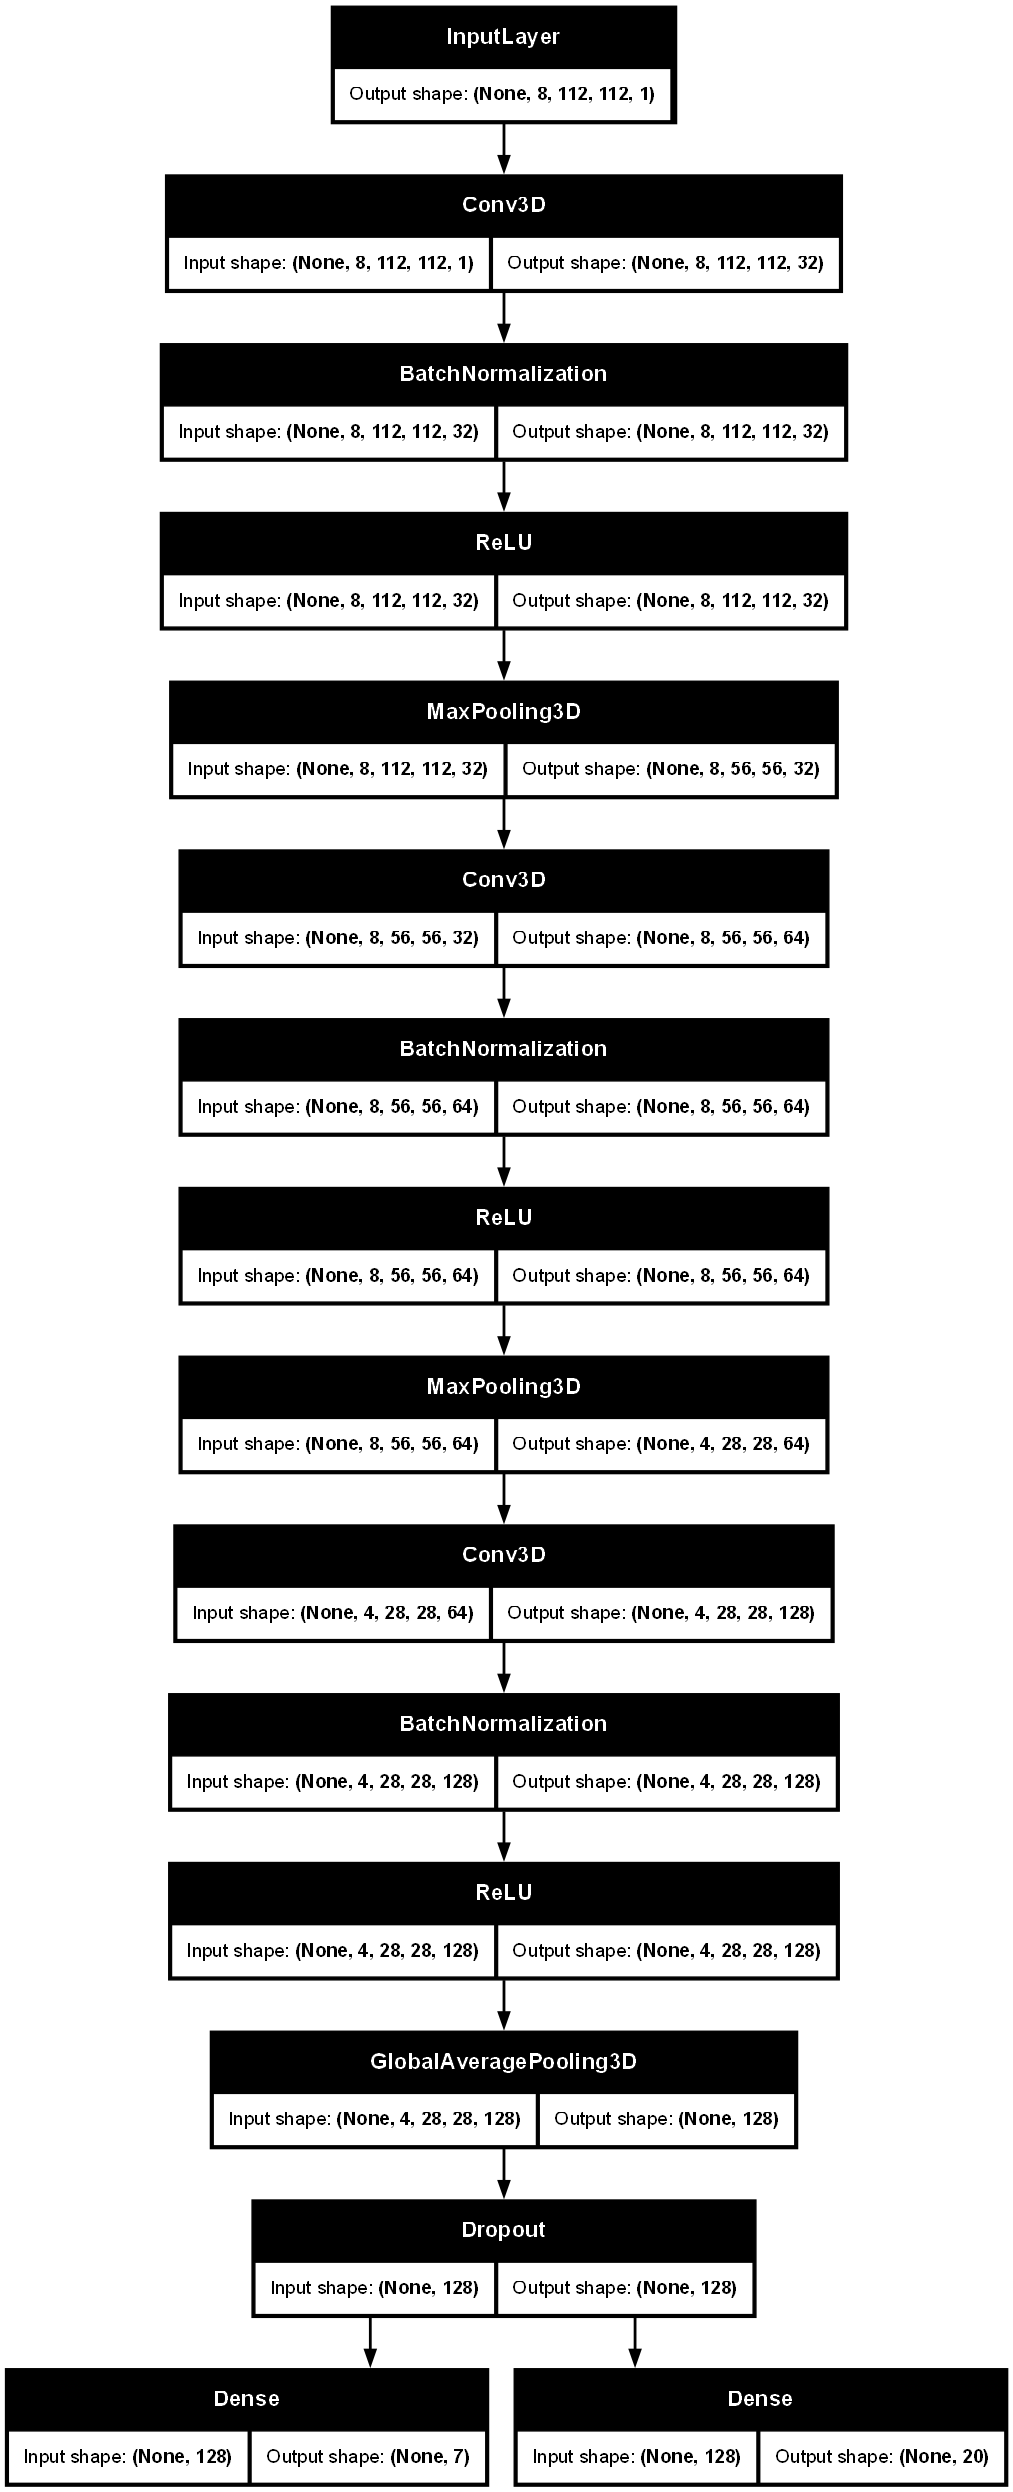

In [8]:
CCN_3D_model = build_3d_cnn()
tf.keras.utils.plot_model(
    CCN_3D_model,
    to_file='CCN_3D_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir='TB',
    expand_nested=False,
    dpi=100,
    show_layer_activations=False,
    show_trainable=False
)

### 2D CNN + BiLSTM

In [9]:
def build_2d_bilstm(input_shape=(8, 112, 112, 1), num_emotions=7, num_aus=12,
                    cnn_feat_dim=256, lstm_hidden=256, lstm_layers=1, dropout=0.3):
    """
    input_shape: (T, H, W, C)
    Uses TimeDistributed 2D encoder, BiLSTM across time, temporal pooling, heads.
    """
    T, H, W, C = input_shape
    video_in = layers.Input(shape=input_shape, name="video_in")  # (T, H, W, C)

    # Apply same 2D encoder to every frame via TimeDistributed
    def frame_encoder():
        inp_f = layers.Input(shape=(H, W, C))
        x = conv_block_2d(inp_f, 32, pool=True)
        x = conv_block_2d(x, 64, pool=True)
        x = conv_block_2d(x, 128, pool=True)
        x = conv_block_2d(x, cnn_feat_dim, pool=False)
        x = layers.GlobalAveragePooling2D()(x)
        return Model(inputs=inp_f, outputs=x, name="frame_encoder")

    encoder = frame_encoder()
    # TimeDistributed encoder: output shape (batch, T, cnn_feat_dim)
    td = layers.TimeDistributed(encoder, name="td_encoder")(video_in)

    # BiLSTM
    rnn = td
    for i in range(lstm_layers):
        return_seq = True if i < (lstm_layers - 1) else True
        rnn = layers.Bidirectional(layers.LSTM(lstm_hidden, return_sequences=return_seq, dropout=dropout if lstm_layers>1 else 0.0),
                                   name=f"bilstm_{i+1}")(rnn)

    # temporal pooling (mean)
    pooled = layers.GlobalAveragePooling1D(name="temporal_mean")(rnn)  # (batch, 2*lstm_hidden)

    pooled = layers.Dropout(dropout)(pooled)
    emotion_logits = layers.Dense(num_emotions, name="emotion_logits")(pooled)
    au_logits = layers.Dense(num_aus, name="au_logits")(pooled)

    model = Model(inputs=video_in, outputs=[emotion_logits, au_logits], name="2D_BiLSTM")
    return model

Architecture plot

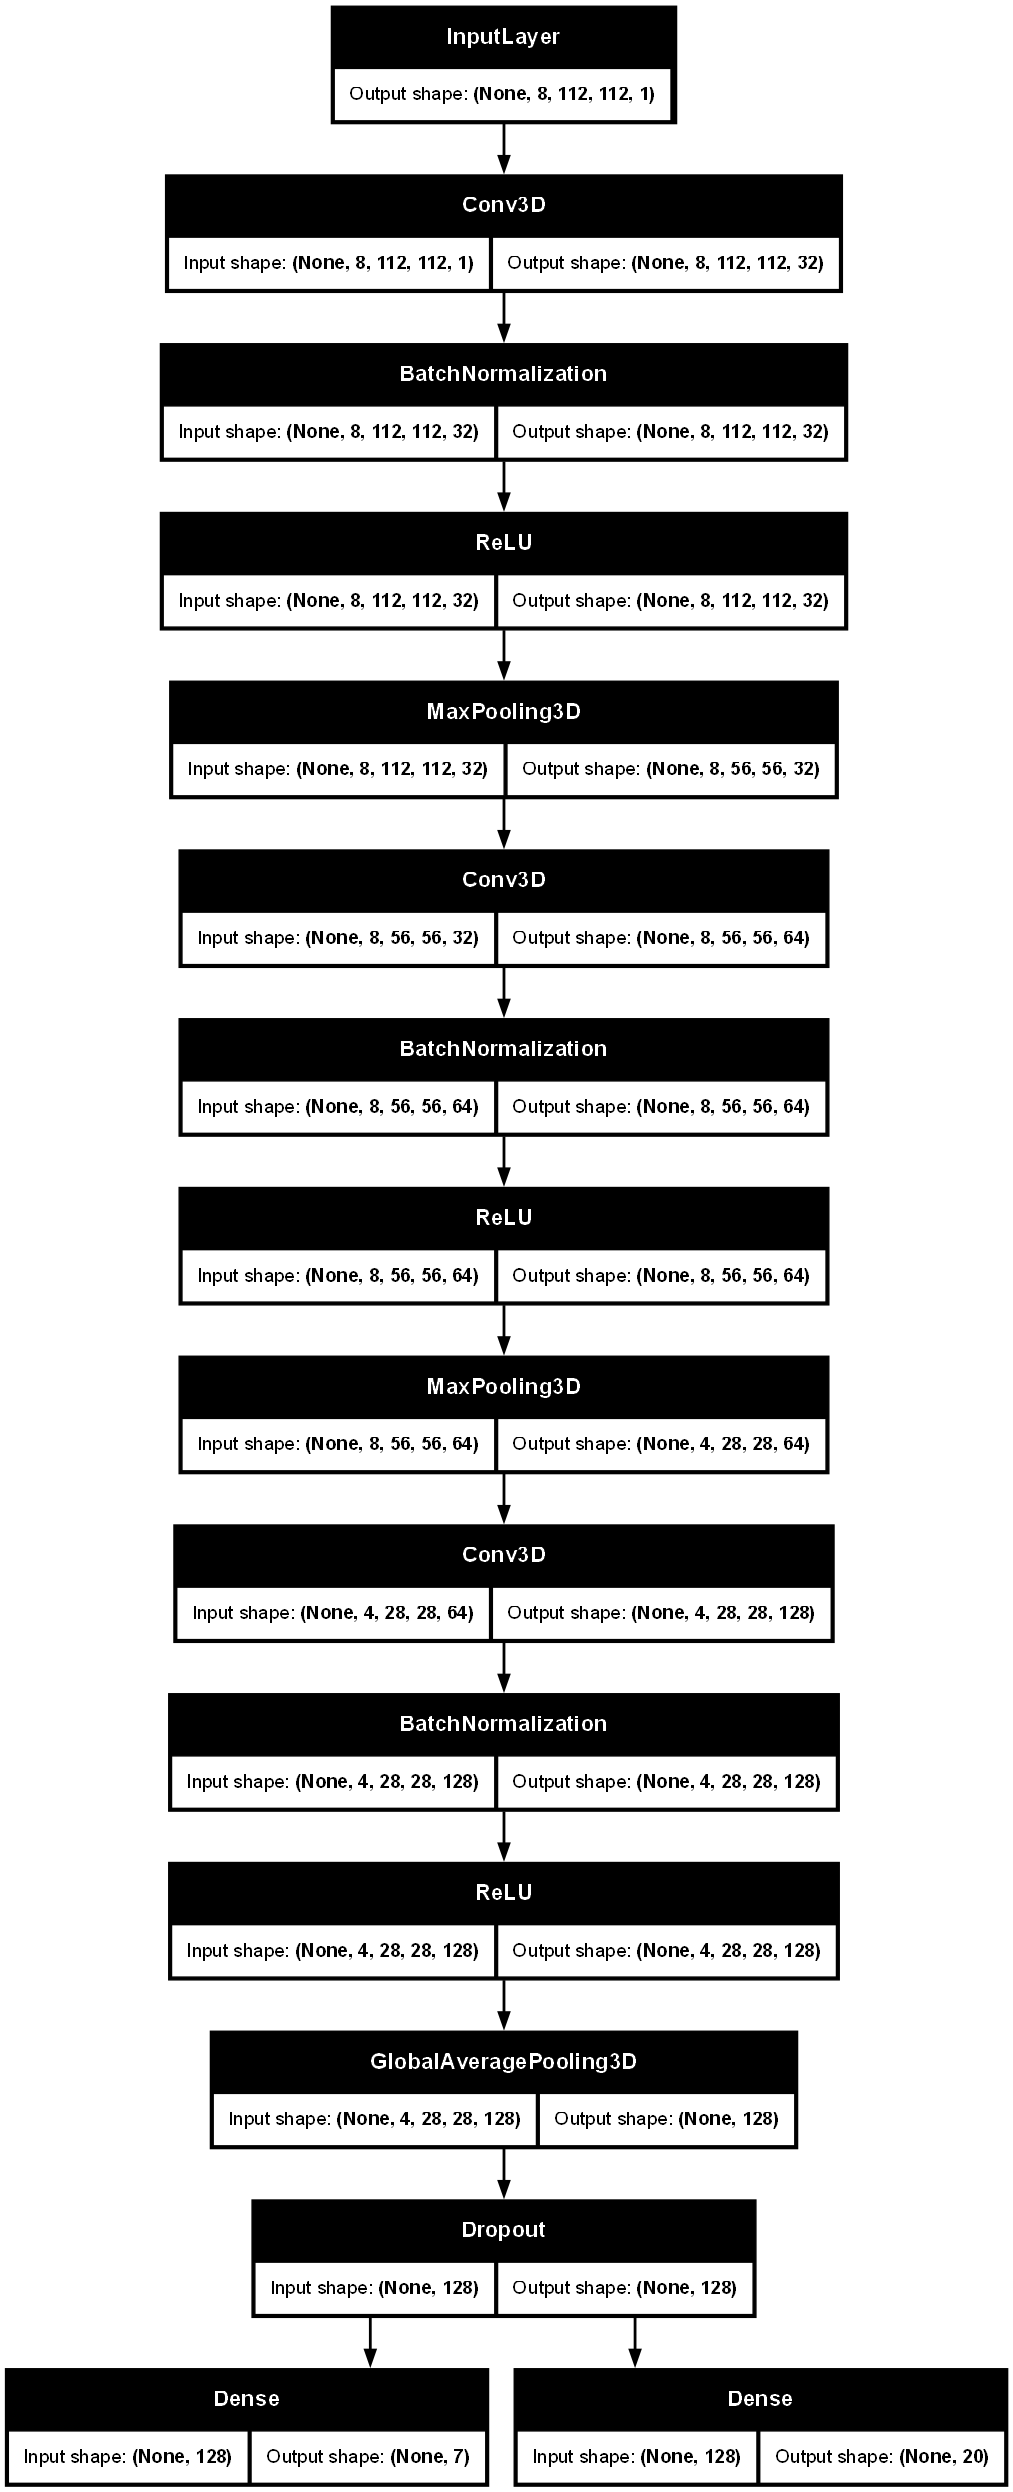

In [11]:
CCN_2DLSTM_model = build_2d_bilstm()
tf.keras.utils.plot_model(
    CCN_3D_model,
    to_file='CCN_2DLSTM_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir='TB',
    expand_nested=False,
    dpi=100,
    show_layer_activations=False,
    show_trainable=False
)

### Transformer

In [13]:
def get_positional_encoding(seq_len, d_model):
    """Sinusoidal positional encoding (seq_len, d_model)"""
    import numpy as np
    pos = np.arange(seq_len)[:, np.newaxis]  # (seq_len,1)
    i = np.arange(d_model)[np.newaxis, :]    # (1,d_model)
    angle_rates = 1 / (10000 ** (2 * (i // 2) / np.float32(d_model)))
    angle_rads = pos * angle_rates
    # sin to even indices, cos to odd indices
    sin = np.sin(angle_rads[:, 0::2])
    cos = np.cos(angle_rads[:, 1::2])
    pe = np.zeros(angle_rads.shape, dtype=np.float32)
    pe[:, 0::2] = sin
    pe[:, 1::2] = cos
    return tf.convert_to_tensor(pe)  # (seq_len, d_model)

def transformer_encoder_block(x, d_model, num_heads, mlp_dim, dropout=0.1, name=None):
    # Multi-head self-attention
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads, name=(None if name is None else name+"_mha"))(x, x)
    attn_output = layers.Dropout(dropout)(attn_output)
    out1 = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)

    # Feed-forward
    ffn = layers.Dense(mlp_dim, activation='relu')(out1)
    ffn = layers.Dense(d_model)(ffn)
    ffn = layers.Dropout(dropout)(ffn)
    out2 = layers.LayerNormalization(epsilon=1e-6)(out1 + ffn)
    return out2

def build_2d_transformer(input_shape=(8, 112, 112, 1), num_emotions=7, num_aus=12,
                         cnn_feat_dim=256, transformer_dim=256, nhead=8, num_layers=3, dropout=0.2):
    """
    Per-frame 2D encoder -> project to transformer_dim -> add positional encoding -> transformer encoder stack
    """
    T, H, W, C = input_shape
    video_in = layers.Input(shape=input_shape, name="video_in")

    # frame encoder (same as before)
    def frame_encoder():
        inp_f = layers.Input(shape=(H, W, C))
        x = conv_block_2d(inp_f, 32, pool=True)
        x = conv_block_2d(x, 64, pool=True)
        x = conv_block_2d(x, 128, pool=True)
        x = conv_block_2d(x, cnn_feat_dim, pool=False)
        x = layers.GlobalAveragePooling2D()(x)
        return Model(inputs=inp_f, outputs=x, name="frame_encoder_tf")
    encoder = frame_encoder()

    td = layers.TimeDistributed(encoder, name="td_encoder")(video_in)

    # project to transformer dim if needed
    if cnn_feat_dim != transformer_dim:
        proj = layers.Dense(transformer_dim, name="proj")(td)
    else:
        proj = td

    # positional encoding (add)
    pe = get_positional_encoding(T, transformer_dim)
    proj = proj + pe[tf.newaxis, ...]

    x = proj
    for i in range(num_layers):
        x = transformer_encoder_block(x, transformer_dim, nhead, mlp_dim=transformer_dim * 4, dropout=dropout, name=f"trans_enc_{i+1}")

    # temporal pooling
    pooled = layers.GlobalAveragePooling1D(name="temporal_mean")(x)
    pooled = layers.Dropout(dropout)(pooled)
    emotion_logits = layers.Dense(num_emotions, name="emotion_logits")(pooled)
    au_logits = layers.Dense(num_aus, name="au_logits")(pooled)

    model = Model(inputs=video_in, outputs=[emotion_logits, au_logits], name="2D_Transformer")
    return model

Architecture plot

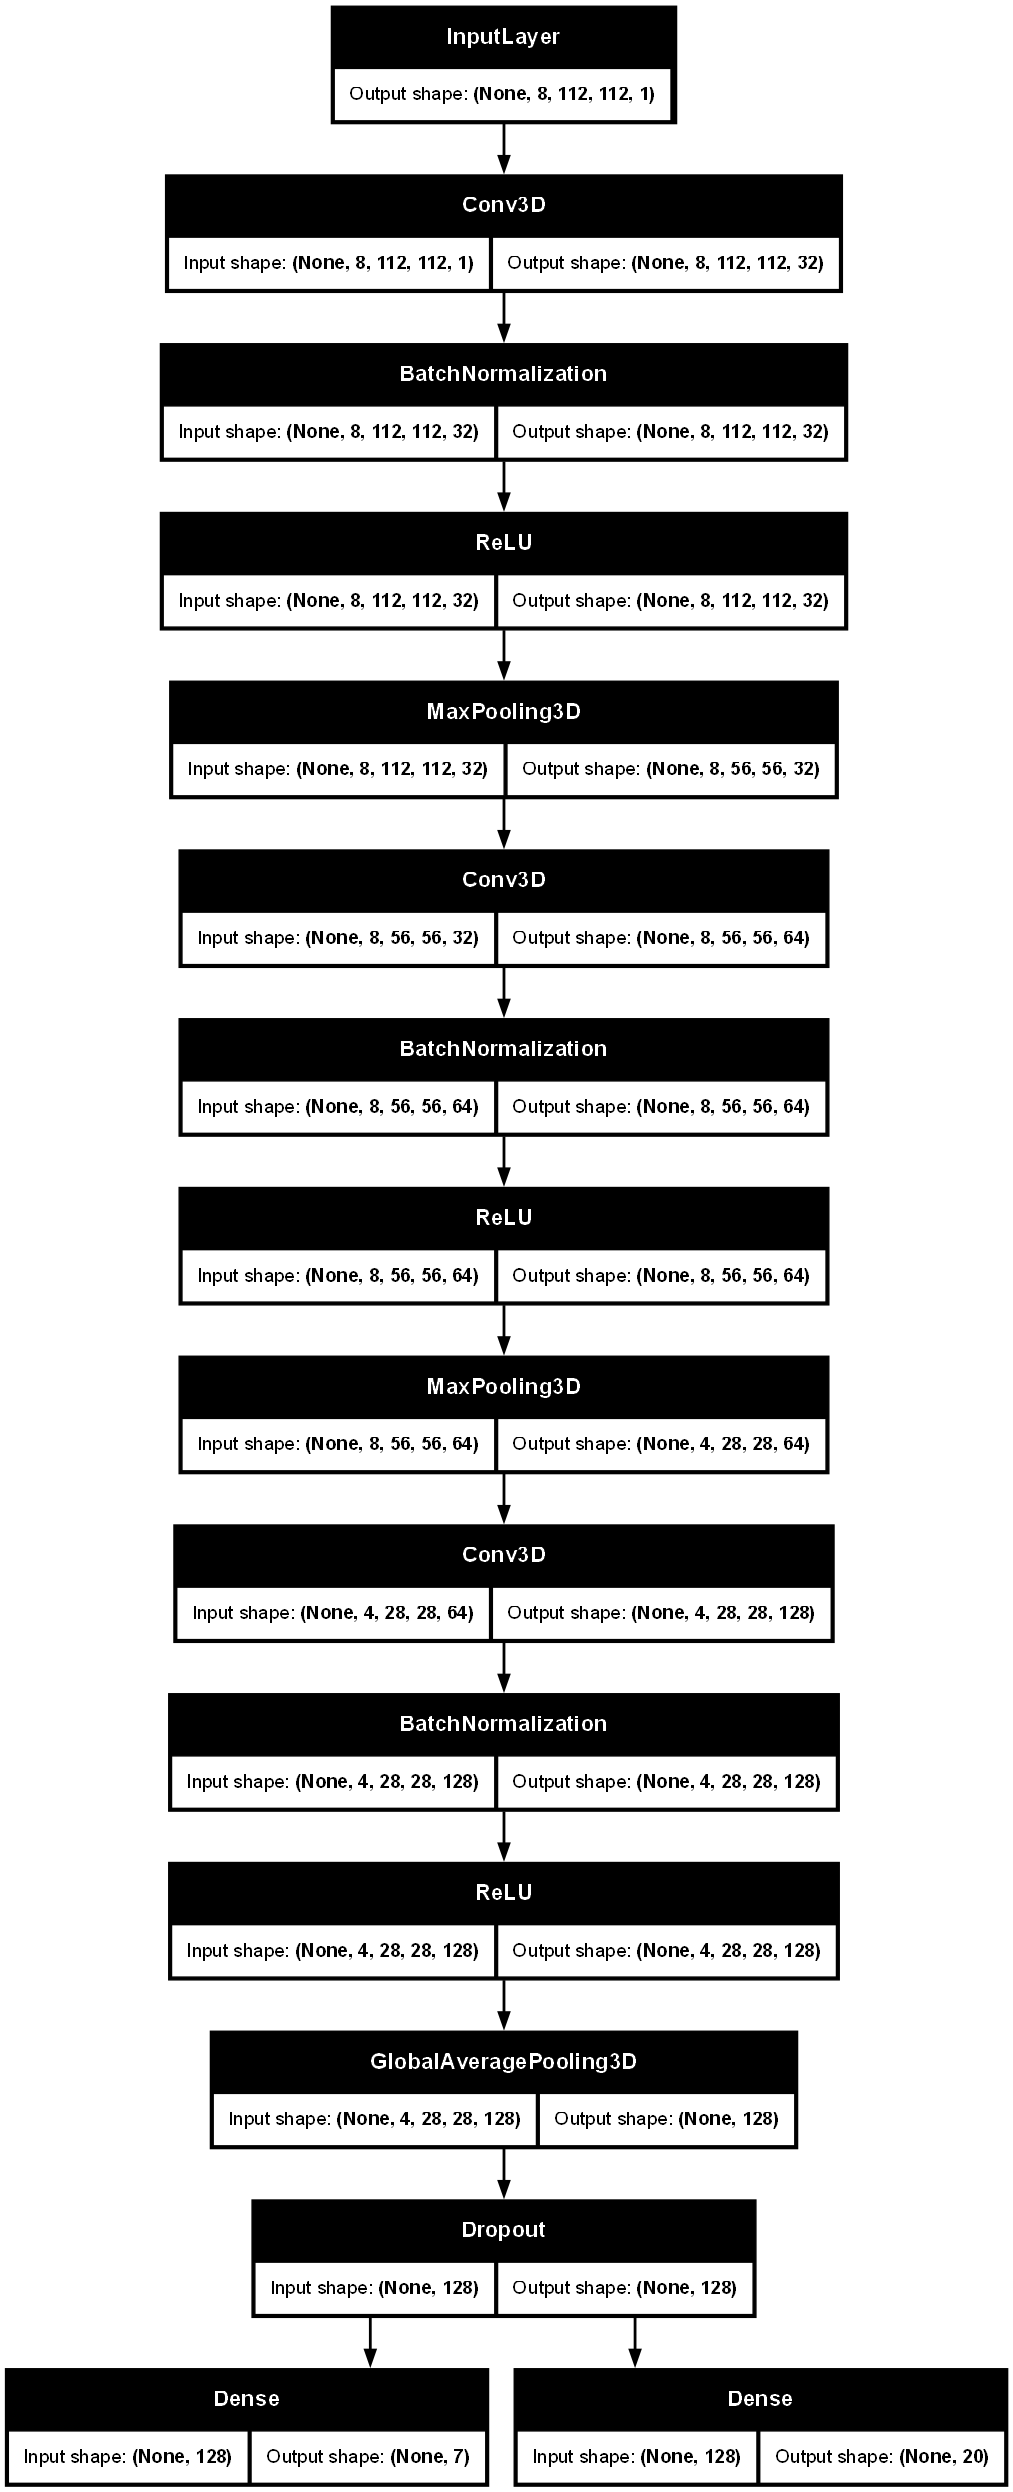

In [14]:
CCN_2DTransformer_model = build_2d_transformer()
tf.keras.utils.plot_model(
    CCN_3D_model,
    to_file='CCN_2DTransformer_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir='TB',
    expand_nested=False,
    dpi=100,
    show_layer_activations=False,
    show_trainable=False
)

### Losses

In [15]:
def compile_model(model, lr=1e-4, emotion_loss_weight=1.0, au_loss_weight=1.0):
    """
    Compile the Keras model with appropriate losses and example metrics.
    emotion: integer labels -> use SparseCategoricalCrossentropy(from_logits=True)
    AUs: multi-label -> use BinaryCrossentropy(from_logits=True)
    """
    loss_emotion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    loss_au = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    losses = {
        "emotion_logits": loss_emotion,
        "au_logits": loss_au
    }
    loss_weights = {"emotion_logits": emotion_loss_weight, "au_logits": au_loss_weight}
    metrics = {
        "emotion_logits": ["sparse_categorical_accuracy"],
        "au_logits": [tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")]
    }
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss=losses, loss_weights=loss_weights, metrics=metrics)
    return model

### Simple Test

In [16]:
if __name__ == "__main__":
    B = 2
    T = 8
    H = 112
    W = 112
    C = 1
    num_emotions = 7
    num_aus = 12

    inp_shape = (T, H, W, C)

    m3 = build_3d_cnn(input_shape=inp_shape, num_emotions=num_emotions, num_aus=num_aus)
    m3 = compile_model(m3)
    m3.summary()

    m2 = build_2d_bilstm(input_shape=inp_shape, num_emotions=num_emotions, num_aus=num_aus)
    m2 = compile_model(m2)
    m2.summary()

    mt = build_2d_transformer(input_shape=inp_shape, num_emotions=num_emotions, num_aus=num_aus)
    mt = compile_model(mt)
    mt.summary()

    # Example forward pass
    import numpy as np
    x = np.random.randn(B, T, H, W, C).astype(np.float32)
    e3, a3 = m3.predict(x)
    e2, a2 = m2.predict(x)
    et, at = mt.predict(x)
    print("Outputs shapes:", e3.shape, a3.shape)

Model: "3D_CNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ video_in            │ (None, 8, 112,    │          0 │ -                 │
│ (InputLayer)        │ 112, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 8, 112,    │        864 │ video_in[0][0]    │
│                     │ 112, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn3d_1              │ (None, 8, 112,    │        128 │ conv3d_1[0][0]    │
│ (BatchNormalizatio… │ 112, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_27 (ReLU)     │ (None, 8, 112,    │          0 │ bn3d_1[0][0]      │
│                     │ 112, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool3d_1            │ (None, 8, 56, 56, │          0 │ re_lu_27[0][0]    │
│ (MaxPooling3D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 8, 56, 56, │     55,296 │ pool3d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn3d_2              │ (None, 8, 56, 56, │        256 │ conv3d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_28 (ReLU)     │ (None, 8, 56, 56, │          0 │ bn3d_2[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool3d_2            │ (None, 4, 28, 28, │          0 │ re_lu_28[0][0]    │
│ (MaxPooling3D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 4, 28, 28, │    221,184 │ pool3d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn3d_3              │ (None, 4, 28, 28, │        512 │ conv3d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_29 (ReLU)     │ (None, 4, 28, 28, │          0 │ bn3d_3[0][0]      │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap3d               │ (None, 128)       │          0 │ re_lu_29[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ gap3d[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emotion_logits      │ (None, 7)         │        903 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ au_logits (Dense)   │ (None, 12)        │      1,548 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 280,691 (1.07 MB)

 Trainable params: 280,243 (1.07 MB)

 Non-trainable params: 448 (1.75 KB)

Model: "2D_BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ video_in            │ (None, 8, 112,    │          0 │ -                 │
│ (InputLayer)        │ 112, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ td_encoder          │ (None, 8, 256)    │    389,280 │ video_in[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm_1            │ (None, 8, 512)    │  1,050,624 │ td_encoder[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ temporal_mean       │ (None, 512)       │          0 │ bilstm_1[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 512)       │          0 │ temporal_mean[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emotion_logits      │ (None, 7)         │      3,591 │ dropout_12[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ au_logits (Dense)   │ (None, 12)        │      6,156 │ dropout_12[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,449,651 (5.53 MB)

 Trainable params: 1,448,691 (5.53 MB)

 Non-trainable params: 960 (3.75 KB)

Model: "2D_Transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ video_in            │ (None, 8, 112,    │          0 │ -                 │
│ (InputLayer)        │ 112, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ td_encoder          │ (None, 8, 256)    │    389,280 │ video_in[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 8, 256)    │          0 │ td_encoder[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ trans_enc_1_mha     │ (None, 8, 256)    │    263,168 │ add_7[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_7[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 8, 256)    │          0 │ trans_enc_1_mha[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 8, 256)    │          0 │ add_7[0][0],      │
│                     │                   │            │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 8, 256)    │        512 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 8, 1024)   │    263,168 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 8, 256)    │    262,400 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 8, 256)    │          0 │ dense_7[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 8, 256)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 8, 256)    │        512 │ add_9[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ trans_enc_2_mha     │ (None, 8, 256)    │    263,168 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 8, 256)    │          0 │ trans_enc_2_mha[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 8, 256)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 8, 256)    │        512 │ add_10[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 8, 1024)   │    263,168 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 8, 256)    │    262,400 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,763,443 (10.54 MB)

 Trainable params: 2,762,483 (10.54 MB)

 Non-trainable params: 960 (3.75 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step
Outputs shapes: (2, 7) (2, 12)
